# Classification de graphes

In [79]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapely
import networkx as nx
import os
import karateclub as kc
import copy

## Construction des graphes pour la classification de graphes

## Prétraitement des données

In [80]:
def preprocessing(gdf, commune, rm_residual_areas=True, object_prop_th=0.50, total_prop_th=0.01):
    assert len(gdf) != 0
    # todo : gérer les nodata
    gdf = gdf.clip(commune["geometry"])

    gdf["total_area"] = gdf.area
    gdf = gdf.drop("Area_Ha", axis="columns")

    gdf = gdf.explode(index_parts=False)
    gdf["object_proportion"] = gdf.area / gdf["total_area"]
    gdf["total_proportion"] = gdf.area / gdf.area.sum()

    if rm_residual_areas is True:
        gdf = gdf[(gdf["object_proportion"] >= object_prop_th) | (gdf["total_proportion"] >= total_prop_th)]

    gdf['Node_ID'] = range(len(gdf))  # pour simplifier la création des graphes
    gdf['Code_18'] = gdf['Code_18'].astype(str)

    return gdf

### Calcul du voisinage

In [81]:
def preprocess_border(border):
    if border.geom_type == "MultiLineString":
        # plusieurs frontières
        border = shapely.ops.linemerge(border)
    return border


def calc_borders(area, neighbors):
    borders_info = {"total_border": [], "greatest_border": [], "nb_borders": []}
    borders = neighbors.geometry.intersection(area.geometry)
    for border in borders:
        border = preprocess_border(border)
        if border.geom_type == "MultiLineString":
            lengths = gpd.GeoSeries(border.geoms).length
            borders_info["total_border"].append(lengths.sum())
            borders_info["greatest_border"].append(max(lengths))
            borders_info["nb_borders"].append(len(lengths))
        else:
            length = border.length
            borders_info["total_border"].append(length)
            borders_info["greatest_border"].append(length)
            borders_info["nb_borders"].append(1)
    return borders_info


def calc_neighbors(gdf):
    neighbors_dict = {"src": [], "dest": [], "total_border": [], "greatest_border": [], "nb_borders": []}

    for index, area in gdf.iterrows():
        neighbors = gdf[gdf.geometry.touches(area.geometry)]
        neighbors = neighbors[~neighbors['Node_ID'].isin(neighbors_dict['src'])]

        dest = neighbors['Node_ID'].tolist()
        src = [area['Node_ID']] * neighbors.shape[0]

        borders = calc_borders(area, neighbors)

        neighbors_dict["src"].extend(src)
        neighbors_dict["dest"].extend(dest)
        neighbors_dict["total_border"].extend(borders["total_border"])
        neighbors_dict["greatest_border"].extend(borders["greatest_border"])
        neighbors_dict["nb_borders"].extend(borders["nb_borders"])

    return neighbors_dict

### Génération des données des graphes

In [82]:
def generate_graph_data(data_path, communes_path):
    graph_properties_dict = {"graph_id": [], "num_nodes": []}
    graph_nodes_dict = {"graph_id": [], "node_id": [], "label": []}
    graph_edges_dict = {"graph_id": [], "src": [], "dest": [], "total_border": [], "greatest_border": [],
                        "nb_borders": []}

    communes = gpd.read_file(communes_path)

    l = len(communes)
    step = int(l * 0.05)
    print(f"Number of instances : {l}")
    i = 1

    for _, commune in communes.iterrows():
        if i % step == 1:
            print(f"{int((i / l) * 100)}%", end="...")

        gdf = preprocessing(gpd.read_file(data_path, mask=commune['geometry']), commune)

        neighbors = calc_neighbors(gdf)

        graph_properties_dict["graph_id"].append(commune['COMM_ID'])
        graph_properties_dict["num_nodes"].append(len(gdf))

        graph_nodes_dict["graph_id"].extend([commune['COMM_ID']] * len(gdf))
        graph_nodes_dict["node_id"].extend(gdf["Node_ID"])
        graph_nodes_dict["label"].extend(gdf["Code_18"])

        graph_edges_dict["src"].extend(neighbors["src"])
        graph_edges_dict["dest"].extend(neighbors["dest"])
        graph_edges_dict["total_border"].extend(neighbors["total_border"])
        graph_edges_dict["greatest_border"].extend(neighbors["greatest_border"])
        graph_edges_dict["nb_borders"].extend(neighbors["nb_borders"])
        graph_edges_dict["graph_id"].extend([commune['COMM_ID']] * len(neighbors["src"]))

        i = i + 1

    print("100%")

    graph_properties_df = pd.DataFrame(graph_properties_dict)
    graph_nodes_df = pd.DataFrame(graph_nodes_dict)
    graph_edges_df = pd.DataFrame(graph_edges_dict)

    return graph_properties_df, graph_nodes_df, graph_edges_df

In [83]:
clc_path = "../data/raw_data/clc/u2018_clc2018_v2020_20u1_geoPackage/DATA/U2018_CLC2018_V2020_20u1.gpkg"
communes_dir = "../data/communes/comm_6_70_90"
communes_path = os.path.join(communes_dir, "communes.gpkg")

In [84]:
graph_properties, graph_nodes, graph_edges = generate_graph_data(clc_path, communes_path)

graph_properties["label"] = graph_properties["graph_id"].str[:2].astype('category').cat.codes

graph_properties.to_csv(os.path.join(communes_dir, "graph_properties.csv"))
graph_nodes.to_csv(os.path.join(communes_dir, "graph_nodes.csv"))
graph_edges.to_csv(os.path.join(communes_dir, "graph_edges.csv"))

Number of instances : 1356
0%...5%...9%...14%...19%...24%...29%...34%...39%...44%...49%...54%...59%...64%...69%...74%...79%...84%...89%...93%...98%...100%


### Quelques statistiques

In [104]:
graph_properties = pd.read_csv(os.path.join(communes_dir, "graph_properties.csv"))
graph_nodes = pd.read_csv(os.path.join(communes_dir, "graph_nodes.csv"))
graph_edges = pd.read_csv(os.path.join(communes_dir, "graph_edges.csv"))

In [105]:
# nombre d'instances
instances = len(graph_properties)
# nombre de classes
classes = len(graph_properties['label'].astype('category').cat.categories)
# nombre de noeuds en moyenne
nodes_groups_sizes = graph_nodes.groupby('graph_id').size()
min_nodes = np.round(nodes_groups_sizes.min(),2)
mean_nodes = np.round(nodes_groups_sizes.mean(),2)
max_nodes = np.round(nodes_groups_sizes.max(),2)
# nombre d'arcs en moyenne
edges_groups_sizes = graph_edges.groupby('graph_id').size()
min_edges = np.round(edges_groups_sizes.min(),2)
mean_edges = np.round(edges_groups_sizes.mean(),2)
max_edges = np.round(edges_groups_sizes.max(),2)
# nombre de labels distincts
labels = len(graph_nodes['label'].astype('category').cat.categories)

In [106]:
print(f"# instances : {instances}")
print(f"# classes : {classes}")
print(f"# nodes (min.) : {min_nodes}")
print(f"# nodes (avg.) : {mean_nodes}")
print(f"# nodes (max.) : {max_nodes}")
print(f"# edges (min.) : {min_edges}")
print(f"# edges (avg.) : {mean_edges}")
print(f"# edges (max.) : {max_edges}")
print(f"# distinct node labels : {labels}")

# instances : 1356
# classes : 6
# nodes (min.) : 5
# nodes (avg.) : 52.76
# nodes (max.) : 121
# edges (min.) : 5
# edges (avg.) : 101.3
# edges (max.) : 284
# distinct node labels : 44


Remarque : on pourrait ensuite supprimer des graphes en fonction d'un nombre min/max de noeuds/arcs

### Création des graphes

In [107]:
# NetworkX dataset
class NxClassDataset():
    def __init__(self, properties_path, nodes_path, edges_path):
        self.properties = pd.read_csv(properties_path)
        self.nodes = pd.read_csv(nodes_path)
        self.edges = pd.read_csv(edges_path)
        self.graphs = []
        self.labels = []
        self.ids = []
        self.process()

    def process(self):
        # Create a graph for each graph ID from the edges table.
        # First process the properties table into two dictionaries with graph IDs as keys.
        # The label and number of nodes are values.
        label_dict = {}
        for _, row in self.properties.iterrows():
            label_dict[row['graph_id']] = row['label']

        # Group by graph IDs
        edges_group = self.edges.groupby('graph_id')
        nodes_group = self.nodes.groupby('graph_id')

        # For each graph ID...
        for graph_id in edges_group.groups:
            edges_of_id = edges_group.get_group(graph_id)
            nodes_of_id = nodes_group.get_group(graph_id)
            label = label_dict[graph_id]

            g = nx.Graph(label=label, id=graph_id)
            for _, row in nodes_of_id.iterrows():
                g.add_node(row['node_id'], feature=str(row['label']))
            for _, row in edges_of_id.iterrows():
                g.add_edge(row['src'], row['dest'], total_border=row['total_border'],
                           greatest_border=row['greatest_border'],
                           nb_borders=row['nb_borders'])

            self.graphs.append(g)
            self.labels.append(label)
            self.ids.append(graph_id)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i], self.ids[i]

    def get_graphs(self):
        return self.graphs

    def get_labels(self):
        return self.labels

    def get_ids(self):
        return self.ids

In [108]:
communes_nx_dataset = NxClassDataset(properties_path=os.path.join(communes_dir, "graph_properties.csv"),
                                     nodes_path=os.path.join(communes_dir, "graph_nodes.csv"),
                                     edges_path=os.path.join(communes_dir, "graph_edges.csv"))

### Visualisation des graphes

In [109]:
def draw_map_graph(nx_graph, gdf, column=None, legend=False, ax=None):
    pos = {}
    points = gdf.representative_point()
    for i in range(len(gdf)):
        area = gdf.iloc[i]
        point = points.iloc[i]
        pos[area['Node_ID']] = (point.x, point.y)

    gdf.plot(column, legend=legend, ax=ax)
    nx.draw(nx_graph, pos=pos, with_labels=True, ax=ax, node_color=[(0, 0, 0, 0.7)], font_color="white")

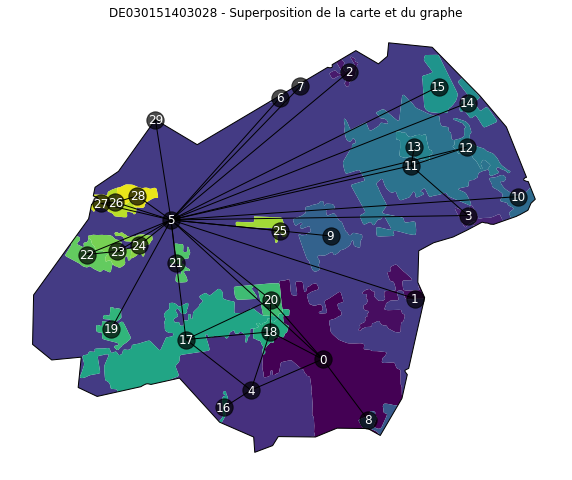

In [110]:
g_nx, g_label, g_id = communes_nx_dataset[5]
f, ax = plt.subplots(figsize=(10, 10))
communes = gpd.read_file(communes_path)
commune = communes[communes['COMM_ID'] == g_id]
gdf = preprocessing(gpd.read_file(clc_path, mask=commune['geometry']), commune)
gdf.dissolve().exterior.plot(ax=ax, color="black", linewidth=1)
draw_map_graph(g_nx, gdf=gdf, column=np.array(range(len(gdf))), ax=ax)
plt.title(f"{g_id} - Superposition de la carte et du graphe")
plt.show()

## Classification des graphes

### Graph embedding

In [111]:
# karate club: https://karateclub.readthedocs.io/en/latest/index.html

In [112]:
graphs = copy.deepcopy(communes_nx_dataset.get_graphs())
labels = communes_nx_dataset.get_labels()

### graph2vec

In [113]:
graph2vec = kc.Graph2Vec(wl_iterations=3, epochs=100, attributed=True)
graph2vec.fit(graphs)

In [114]:
g2v_dataset = graph2vec.get_embedding()
g2v_dataset[0]

array([-9.62992664e-03, -3.14531356e-01, -1.94160178e-01, -3.58976364e-01,
       -4.85488921e-01, -2.38599390e-01,  1.07101035e+00, -1.94562703e-01,
       -1.50102347e-01, -2.21811473e-01, -2.78707683e-01,  3.31954956e-01,
       -4.31253403e-01, -4.74352539e-02,  2.24588767e-01, -2.75462661e-02,
        2.20340356e-01,  2.38095820e-02, -4.69517380e-01,  2.11065531e-01,
       -4.20759767e-01, -2.01868936e-01, -3.36585402e-01, -1.45736232e-01,
       -1.03077561e-01, -5.75199425e-02,  4.24703240e-01, -8.35651590e-04,
       -9.98980820e-01, -2.46397495e-01, -5.52880406e-01,  1.74753502e-01,
        1.39131173e-01, -2.36827552e-01, -1.14770874e-01,  6.62721694e-01,
       -3.22366267e-01,  8.06707144e-02,  3.85222673e-01, -2.29699090e-01,
       -2.10325480e-01,  1.71712235e-01,  2.65891612e-01, -1.89874619e-01,
       -2.29232907e-01,  4.79762703e-01, -2.41669029e-01,  3.91539097e-01,
       -8.92176703e-02,  3.28193814e-01,  8.34173501e-01,  1.66393369e-01,
       -1.82848051e-02, -

## Classification

In [115]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(g2v_dataset, np.array(labels),
                                                    test_size=0.2)

In [116]:
from tensorflow import keras


def make_model(input_shape):
    return keras.models.Sequential([
        keras.layers.Input(input_shape),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l1(0.01)),
        keras.layers.Dense(7, activation='softmax')
    ])

In [117]:
model = make_model(X_train[0].shape)

In [118]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 7)                 119       
                                                                 
Total params: 10,983
Trainable params: 10,983
Non-trainable params: 0
_________________________________________________________________


In [119]:
model.compile(optimizer=keras.optimizers.SGD(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [120]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=500, validation_split=0.2,
                    callbacks=[early_stopping_cb])

Epoch 1/500
28/28 [==============================] - 0s 5ms/step - loss: 2.8421 - accuracy: 0.2203 - val_loss: 2.8003 - val_accuracy: 0.2442
Epoch 2/500
28/28 [==============================] - 0s 2ms/step - loss: 2.7673 - accuracy: 0.2537 - val_loss: 2.7361 - val_accuracy: 0.2811
Epoch 3/500
28/28 [==============================] - 0s 2ms/step - loss: 2.6993 - accuracy: 0.2930 - val_loss: 2.6737 - val_accuracy: 0.3318
Epoch 4/500
28/28 [==============================] - 0s 2ms/step - loss: 2.6321 - accuracy: 0.3356 - val_loss: 2.6096 - val_accuracy: 0.3594
Epoch 5/500
28/28 [==============================] - 0s 1ms/step - loss: 2.5611 - accuracy: 0.4025 - val_loss: 2.5375 - val_accuracy: 0.4240
Epoch 6/500
28/28 [==============================] - 0s 2ms/step - loss: 2.4862 - accuracy: 0.4775 - val_loss: 2.4631 - val_accuracy: 0.4885
Epoch 7/500
28/28 [==============================] - 0s 2ms/step - loss: 2.4071 - accuracy: 0.5421 - val_loss: 2.3836 - val_accuracy: 0.5530
Epoch 8/500
2

In [121]:
model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 751us/step - loss: 0.6463 - accuracy: 0.8456


[0.6463274359703064, 0.845588207244873]

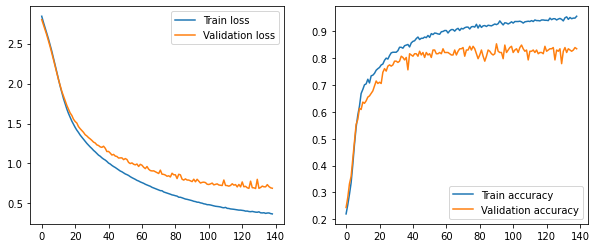

In [122]:
training_loss = history.history['loss']
training_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

import matplotlib.pyplot as plt

f = plt.figure(figsize=(10, 4))
ax = plt.subplot(121)
plt.plot(training_loss, label="Train loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
ax = plt.subplot(122)
plt.plot(training_acc, label="Train accuracy")
plt.plot(val_acc, label="Validation accuracy")
plt.legend()
plt.show()